In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
import os
#from sklearn.model_selection import train_test_split
#import sklearn.preprocessing
from sklearn.svm import SVC
from sklearn.externals import joblib

Using TensorFlow backend.


In [2]:
seed = np.random.seed(7)

In [3]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
npixel = (96,96)
input = Input(shape=(npixel[1],npixel[0],3),name = 'image_input')

In [5]:
x = model_vgg16_conv(input) 
x = Flatten(name='flatten')(x)
#x = Dense(4096, activation='relu', name='fc1')(x)
x

<tf.Tensor 'flatten/Reshape:0' shape=(?, ?) dtype=float32>

In [6]:
feature_extractor = Model(input = input, output = x)
feature_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("fl...)`
  """Entry point for launching an IPython kernel.


In [7]:
black_image = np.zeros(shape = (1,96,96,3))
pred = feature_extractor.predict(black_image)
pred.shape

(1, 4608)

In [8]:
np_path = '/home/kevin/Desktop/OpenFoodFacts/data/npy'
train_np_path = os.path.join(np_path, 'train.npy')
X_train = np.load(train_np_path)

In [9]:
X_train.shape

(17472, 96, 96, 3)

In [10]:
train_bis = feature_extractor.predict(X_train)

In [10]:
np_path = '/home/kevin/Desktop/OpenFoodFacts/data/npy'
train_bis_np_path = os.path.join(np_path, 'train_bis.npy')

In [ ]:
np.save(train_bis_np_path, train_bis)

In [11]:
train_bis = np.load(train_bis_np_path)

In [12]:
train_bis.shape

(17472, 4608)

In [13]:
train_labels_np_path = os.path.join(np_path, 'train_labels.npy')
train_labels = np.load(train_labels_np_path)

In [14]:
train_labels[:,0].shape

(17472,)

In [15]:
clf = SVC()
clf.fit(train_bis, train_labels[:,0])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
model_path = '/home/kevin/Desktop/OpenFoodFacts/data/model'
svm_path = os.path.join(model_path, 'svm.pkl')

In [18]:
joblib.dump(clf, svm_path) 

['/home/kevin/Desktop/OpenFoodFacts/data/model/svm.pkl']

In [19]:
clf = joblib.load(svm_path) 

In [20]:
np_path = '/home/kevin/Desktop/OpenFoodFacts/data/npy'
test_path = os.path.join(np_path, 'test.npy')
test_labels_path = os.path.join(np_path, 'test_labels.npy')
Y_test = np.load(test_labels_path)
X_test = np.load(test_path)

In [22]:
X_test.shape

(7488, 96, 96, 3)

In [23]:
test_bis = feature_extractor.predict(X_test)

In [47]:
np_path = '/home/kevin/Desktop/OpenFoodFacts/data/npy'
test_bis_np_path = os.path.join(np_path, 'test_bis.npy')

In [48]:
np.save(test_bis_np_path, test_bis)

In [28]:
y_pred = clf.predict(test_bis)

In [42]:
Y_test.T[0]

array([False,  True, False, ..., False, False,  True], dtype=bool)

In [44]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3677    3]
 [3797   11]]
Normalized confusion matrix
[[  9.99e-01   8.15e-04]
 [  9.97e-01   2.89e-03]]


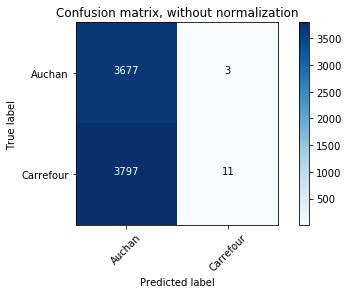

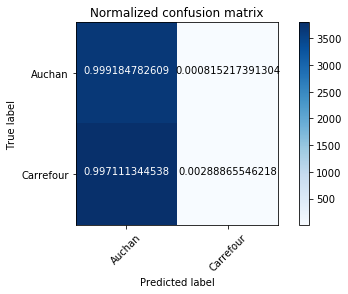

In [46]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(Y_test.T[0], y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['Auchan','Carrefour']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [50]:
clf.score(test_bis, Y_test.T[0])

0.49252136752136755